In [ ]:
!pip install dynamiqs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Success

In [ ]:
import dynamiqs as dq
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

# Task 2.1: Lab frame simulation

In [ ]:
omega_a = 5.26  # eigenfrequency of the mode
omega_b = 7.7 # eigenfrequency of the mode

phi_a = 0.06
phi_b = 0.29

E_J = 12.03
dE_J = 0.47

epsilon_d = -3.815e-3 # drive strength
omega_d = 7.623
omega_p = 2.891

kappa_a = 9.3e-6 # single-photon loss rate
kappa_b = 2.6e-3

e_p = 0.122

na = 5 # Hilbert space size
nb = 5

a = dq.tensor(dq.destroy(na), dq.eye(nb)) # annihilation operator
adag = a.dag() # creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb)) # annihilation operator
bdag = b.dag() # creation operator

phi = phi_a * (a + adag) + phi_b * (b + bdag)

# We also experimented with approximating the hamiltonians
# sin_phi = phi - (1/6)*(phi @ phi @ phi) # third order approximation
# cos_phi = I - (1/2)*(phi @ phi)

sin_phi = dq.sinm(phi)
cos_phi = dq.cosm(phi)

psi0 = dq.tensor(dq.coherent(na, 0.0), dq.coherent(nb, 0.0)) # start in the vaccum

/usr/local/lib/python3.11/dist-packages/equinox/_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)


In [ ]:
H_0 = omega_a * adag @ a + omega_b * bdag @ b

H_AST_1 = dq.modulated(lambda t: -2 * E_J * jnp.sin(e_p * jnp.cos(omega_p * t)), sin_phi)
H_AST_2 = dq.modulated(lambda t: 2 * dE_J * jnp.cos(e_p * jnp.cos(omega_p * t)), cos_phi)

H_d = dq.modulated(lambda t: 2*epsilon_d*jnp.cos(omega_d*t), b + bdag)

H = H_0 + H_d + H_AST_1 + H_AST_2

tsave = jnp.linspace(0, 10, 100)

res = dq.mesolve(H, [jnp.sqrt(kappa_a)*a + jnp.sqrt(kappa_b)*b], psi0, tsave)

res_a = dq.ptrace(res.states, 0)
res_b = dq.ptrace(res.states, 1)

|          |   0.1% ◆ elapsed 1.69ms ◆ remaining 0.00ms

In [ ]:
print(res.states.shape)
print(dq.ptrace(res.states, 0).shape)

(100, 25, 25)
(100, 5, 5)


|█▏        |  12.2% ◆ elapsed 23.60ms ◆ remaining 0.00ms

|██        |  20.1% ◆ elapsed 51.95ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 239.21ms ◆ remaining 0.00ms

100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


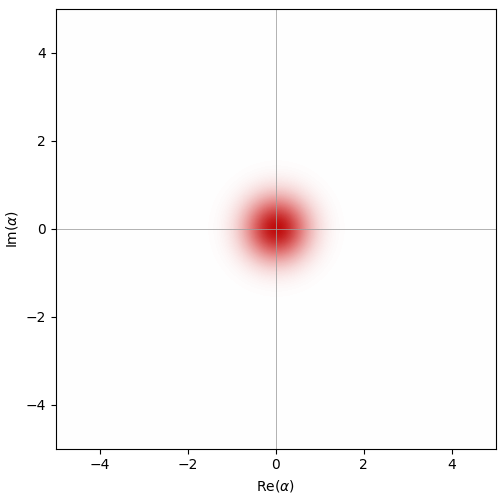

In [ ]:
dq.plot.wigner_gif(res_a, fps=24, cross=True)

A longer simulation of our code is in our slideshow due to the size of the GIF file.

### Task 2.2 Rotated-displaced frame simulation

The first part is our first attempt at this simulation. The second part takes into consideration the hints document posted during the hackathon.

In [ ]:
# @title **2.2**
def xi_a(t):
    return (-1j * E_J * e_p * phi_a) / (kappa_a/2 + 1j*(omega_a - omega_p)) * jnp.exp(-1j * omega_p * t)

def xi_b(t):
    return (-1j * E_J * e_p * phi_b) / (kappa_b/2 + 1j*(omega_b - omega_p)) * jnp.exp(-1j * omega_p * t)

def dxi_a(t):
    return -1j * omega_p * xi_a(t)

def dxi_b(t):
    return -1j * omega_p * xi_b(t)

I = dq.tensor(dq.eye(na), dq.eye(nb))

def a_rotated(t):
    return a + xi_a(t) * I

def adag_rotated(t):
    return adag + jnp.conj(xi_a(t)) * I

def b_rotated(t):
    return b + xi_b(t) * I

def bdag_rotated(t):
    return bdag + jnp.conj(xi_b(t)) * I

def phi_rotated(t):
    return phi_a * (a_rotated(t) + adag_rotated(t)) + phi_b * (b_rotated(t) + bdag_rotated(t))

def sin_phi_rotated(t):
    return a_rotated(t) - (1/6)*(a_rotated(t) @ a_rotated(t) @ a_rotated(t))

def cos_phi_rotated(t):
    return I - (1/2)*(b_rotated(t) @ b_rotated(t))

# H_ATS = -2 * E_J * np.sin(e) * np.sin(phi) + 2 * dE_J * np.cos(e) * np.cos(phi)

H_0_rotated = dq.timecallable(lambda t: omega_a * adag_rotated(t) @ a_rotated(t) + omega_b * bdag_rotated(t) @ b_rotated(t))

H_ATS_rotated = dq.timecallable(lambda t: -2 * E_J * jnp.sin(e_p * jnp.cos(omega_p * t)) * sin_phi_rotated(t) )#+ 2 * dE_J * jnp.cos(e_p * jnp.cos(omega_p * t)) * cos_phi_rotated(t))

H_d_rotated = dq.timecallable(lambda t: 2*epsilon_d*jnp.cos(omega_d*t) * (b_rotated(t) + bdag_rotated(t)))

H_nu = dq.timecallable(lambda t: 1j * (jnp.conj(dxi_a(t))*a - dxi_a(t)*adag + jnp.conj(dxi_b(t))*b - dxi_b(t)*bdag))
# H = dq.timecallable(lambda t: 1j * (jnp.conj(dxi_b(t))*b - dxi_b(t)*bdag))


H_rotated = H_0_rotated + H_ATS_rotated + H_d_rotated + H_nu

L = dq.timecallable(lambda t: jnp.sqrt(kappa_a)*(a + xi_a(t)*I) + jnp.sqrt(kappa_b)*(b + xi_b(t)*I))

tsave = jnp.linspace(0, 10, 100)

res_rotated = dq.mesolve(H_rotated, [L], psi0, tsave)

res_a_rotated = dq.ptrace(res_rotated.states, 0)
res_b_rotated = dq.ptrace(res_rotated.states, 1)

|██████    |  60.2% ◆ elapsed 113.99ms ◆ remaining 73.59ms

100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


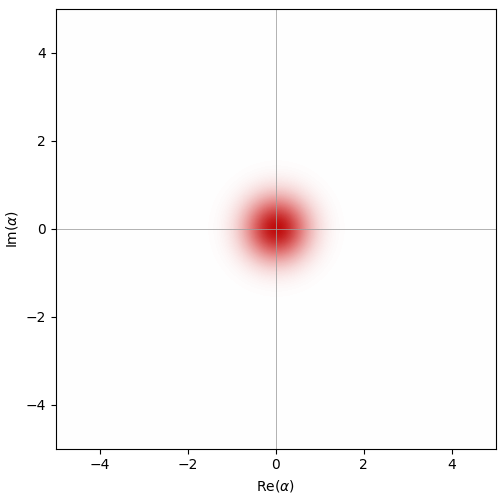

In [ ]:
dq.plot.wigner_gif(res_a_rotated, fps=24, cross=True)

### Constants
Note that code for the following part of this section was supported by the hints document.

In [ ]:
GHz = 1.0
MHz = 1e-3 * GHz
kHz = 1e-3 * MHz

omega_a_0 = 5.26 * GHz # bare resonant frequency of mode a
omega_b_0 = 7.7 * GHz # bare resonant frequency of mode b

phi_a = 0.06 # zero-point fluctuation phase of mode a
phi_b = 0.29 # zero-point fluctuation phase of mode a
e_J = 12.03 * GHz # Josephson energy
delta_e_J = 0.47 * GHz

kappa_a = 9.3 * kHz # relaxation rate of mode a
kappa_b = 2.6 * MHz # relaxation rate of mode b

g2_target = 0.763*MHz # target g2 used to specify driving strength of ATS
alpha_target = np.sqrt(5.0) # target alpha, (or equivalently specify number of photons)

#driving strengths:
epsilon_p = 2*g2_target/(e_J * phi_a**2 * phi_b) # flux pump power
epsilon_d = -alpha_target**2 * np.conj(g2_target) # buffer pump power

#initialization:
delta_a, delta_b = (0.0,0.0) # set initial AC Stark shifts to zero
omega_p = 2*omega_a_0 - omega_b_0 # initial frequency matching condition

#recursion loop to compute AC Stark shift:
rec_depth = 30
for i in range(rec_depth):
    #compute xi for mode a and b:
    alpha_1 = 1j*e_J*epsilon_p*phi_a / (kappa_a/2 + 1j*(omega_a_0 - omega_p))
    alpha_2 = 1j*e_J*epsilon_p*phi_a / (kappa_a/2 + 1j*(omega_a_0 + omega_p))

    beta_1 = 1j*e_J*epsilon_p*phi_b / (kappa_b/2 + 1j*(omega_b_0 - omega_p))
    beta_2 = 1j*e_J*epsilon_p*phi_b / (kappa_b/2 + 1j*(omega_b_0 + omega_p))

    pre = (np.real(alpha_1) + np.real(alpha_2)) * phi_a \
    + (np.real(beta_1) + np.real(beta_2)) * phi_b
    #compute AC Stark shifts:
    delta_a = 1/3*e_J * epsilon_p * phi_a**2 * pre
    delta_b = 1/3*e_J * epsilon_p * phi_b**2 * pre

    #recompute frequencies
    omega_a = omega_a_0 - 2*delta_e_J*phi_a**2 + delta_a
    omega_b = omega_b_0 - 2*delta_e_J*phi_b**2 + delta_b
    omega_p = 2*omega_a - omega_b

omega_d = omega_b

### Smaller operators

In [ ]:
#Fock-space dimension in the memory mode:
n_fock_a = 20
#Fock-space dimension in the buffer mode:
n_fock_b = 5

#annihilation operators:
a, b = dq.destroy(n_fock_a, n_fock_b)

#identity operator:
identity = dq.tensor(dq.eye(n_fock_a), dq.eye(n_fock_b))

# define the ATS driving term
eps_ats = lambda t: epsilon_p*jnp.cos(omega_p*t)

def op_rot_displaced(t, op, omega_rot, dis):
    return op*jnp.exp(-1j*omega_rot*t) + dis * identity

Hamiltonian and Loss

In [ ]:
def hamiltonian_rotating_displaced(t):

    #compute displacement fields
    alpha_t = alpha_1*jnp.exp(-1j*omega_p*t) + alpha_2*jnp.exp(1j*omega_p*t)
    beta_t = beta_1*jnp.exp(-1j*omega_p*t) + beta_2*jnp.exp(1j*omega_p*t)


    # the displaced rotating frame introduces a drive and detuning
    d_alpha_t = 1j*omega_p * (alpha_2*jnp.exp(1j*omega_p*t) - alpha_1*jnp.exp(-1j*omega_p*t))
    d_beta_t = 1j*omega_p * (beta_2*jnp.exp(1j*omega_p*t) - beta_1*jnp.exp(-1j*omega_p*t))


    #compute rotated displaced operators:
    #...
    omega_rot_a = (omega_p + omega_d) / 2
    omega_rot_b = omega_d
    I = identity
    a_f = op_rot_displaced(t, a, omega_rot_a, alpha_t)
    adag_f = op_rot_displaced(t, a.dag(), -omega_rot_a, jnp.conj(alpha_t))
    b_f = op_rot_displaced(t, b, omega_rot_b, beta_t)
    bdag_f = op_rot_displaced(t, b.dag(), -omega_rot_b, jnp.conj(beta_t))

    #displaced rotated phase operator
    phi_f = phi_a*(a_f + adag_f) + phi_b*(b_f + bdag_f)

    #linear term
    h_0 = omega_a_0 * adag_f @ a_f + omega_b_0 * bdag_f @ b_f

    #term from derivative of rotating frame
    h_rot = - omega_rot_a * dq.dag(a) @ a  - omega_rot_b * dq.dag(b) @ b

    #term from derivative of displaced frame
    h_dis =  -1j*(d_alpha_t*dq.dag(a)*jnp.exp(1j*omega_rot_a*t)-jnp.conj(d_alpha_t)*a*jnp.exp(-1j*omega_rot_a*t)) \
      - 1j*(d_beta_t*dq.dag(b)*jnp.exp(1j*omega_rot_b*t)-jnp.conj(d_beta_t)*b*jnp.exp(-1j*omega_rot_b*t))


    #ats term:
    sinterm = jnp.sin(eps_ats(t)) * dq.sinm(phi_f)
    costerm = jnp.cos(eps_ats(t)) * dq.cosm(phi_f)
    h_ats = - 2*e_J*sinterm +  2*delta_e_J*costerm

    #drive on the buffer:
    # in the rotating frame, this term is non-rotating
    h_buffer_drive = jnp.conj(epsilon_d)*jnp.exp(1j*omega_d*t)*b_f \
        + epsilon_d * jnp.exp(-1j*omega_d*t) * bdag_f

    return h_0 + h_ats + h_buffer_drive + h_rot + h_dis

In [ ]:
# Make Hamiltonian time-callable JAX function:
H = dq.timecallable(hamiltonian_rotating_displaced)

In [ ]:
def loss(t):
    #compute displacement fields
    alpha_t = alpha_1*jnp.exp(-1j*omega_p*t) + alpha_2*jnp.exp(1j*omega_p*t)
    beta_t = beta_1*jnp.exp(-1j*omega_p*t) + beta_2*jnp.exp(1j*omega_p*t)

    omega_rot_a = (omega_p + omega_d) / 2
    omega_rot_b = omega_d
    a_f = op_rot_displaced(t, a, omega_rot_a, alpha_t)
    b_f = op_rot_displaced(t, b, omega_rot_b, beta_t)
    return jnp.sqrt(kappa_a)*a_f + jnp.sqrt(kappa_b)*b_f

### Simulation

In [ ]:
psi0 = dq.tensor(dq.coherent(n_fock_a, 0.0), dq.coherent(n_fock_b, 0.0)) # start in the vaccum

tsave = jnp.linspace(0, 5000, 100)

lop = dq.timecallable(loss)
res = dq.mesolve(H, [lop], psi0, tsave)#, solver = dq.solver.Tsit5(max_steps=100_0000))

res_a = dq.ptrace(res.states, 0)
res_b = dq.ptrace(res.states, 1)

dq.plot.wigner_gif(res_a)

For storing and loading results

In [ ]:
import pickle
pickle.dump(res, open("results_yayy.pkl", "wb"))
# res = pickle.load(open("results_yayy.pkl", "rb"))

See below in the fidelity comparison for the simulation result GIF.

The largest difference between this simulation and the one in section 2.1 is that this no longer spins around rapidly nor oscillates around the center.

# Task 2.3: Compating Parities


First, redo-ing 1.1 for the parity check:

In [ ]:
na = 30 # Hilbert space dimension
nb = 5

g2 = 1.0
ed = -4.0
kb = 10 # two-photon loss rate

a = dq.tensor(dq.destroy(na), dq.eye(nb)) # annihilation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0)) # initial state

H = (g2 * a @ a @ b.dag()) + (g2 * a.dag() @ a.dag() @ b) + (ed * b) + (ed * b.dag()) # Hamiltonian

# alpha = 2.0 # cat size
T = 4
tsave = np.linspace(0, T, 100)

loss_op = jnp.sqrt(kb) * b

exp_ops = [dq.dag(a) @ a]

res_111 = dq.mesolve(H, [loss_op], psi0, tsave, exp_ops=exp_ops)

|          |   0.2% ◆ elapsed 28.80ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 1.97s ◆ remaining 0.00ms

100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


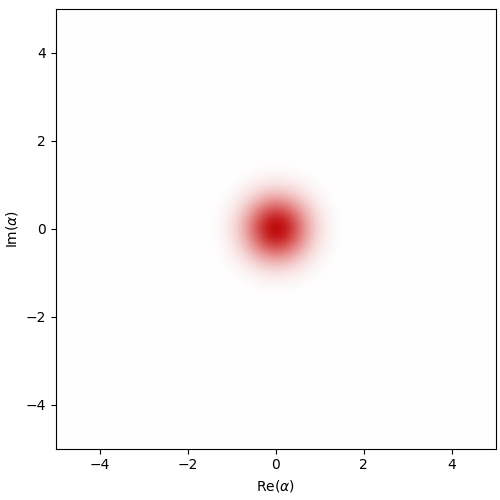

In [ ]:

A = dq.ptrace(res_111.states, 0)
dq.plot.wigner_gif(A)

In [ ]:
import pickle

In [ ]:
result = pickle.load(open('/results_yayy.pkl', 'rb'))
A_result = dq.ptrace(result.states, 0)

100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


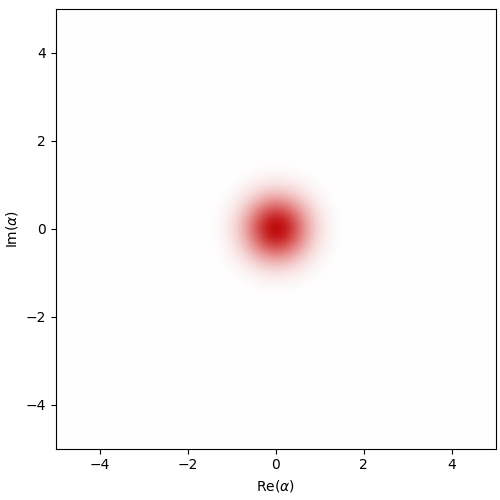

In [ ]:
dq.plot.wigner_gif(A_result)

Now doing the fidelity calculations:

In [ ]:
fidelity_value_1 = dq.fidelity(A_result[-1], A[-1])
time = np.linspace(0, 4, 100)

print(fidelity_value_1)

0.0050154836


The fidelity matches what we observe visually: the resulting state is not quite a cat state.

# Task 2.4 Optimal control

Consider the parameters that we used to simulate the system:
"""
omega_a = 5.26  # eigenfrequency of the mode
omega_b = 7.7 # eigenfrequency of the mode

phi_a = 0.06
phi_b = 0.29

E_J = 12.03 # <-- is this wrong? 42.67
dE_J = 0.47

epsilon_d = -3.815e-3 # drive strength
omega_d = 7.623
omega_p = 2.891

kappa_a = 9.3e-6 # single-photon loss rate
kappa_b = 2.6e-3

e_p = 0.122
""".

The only ones that are feasible to tune given an existing fabricated chip are epsilon_d, omega_d, omega_p, and epsilon_p.

We looked into the effects of epsilon_d on the fidelity results in this curcuit.

Instead of epsilon_d = -alpha_target**2 * np.conj(g2_target) we used epsilon_d = jnp.linspace(-5, -11, 3) and changed references to epsilon_d to epsilon_d[:, None, None] to take advantage of batching in Dynamiqs.

The following code graphs the fidelity of the mode a over time compared to the even cat state

In [ ]:
for i in range(res.states.shape[0]):
    # Compure the ptrace for the a mode
    A = dq.ptrace(res.states, 0)[i]

    plt.plot(tsave, dq.fidelity(dq.unit(dq.coherent(n_fock_a, alpha_target) + dq.coherent(n_fock_a, -alpha_target)), A), label=f"epsilon_d = {epsilon_d[i]}")
    plt.xlabel("Time")
    plt.ylabel("Fidelity")
    plt.title("Fidelity over time for various epsilon_d values")
plt.legend()
plt.grid()
plt.show()

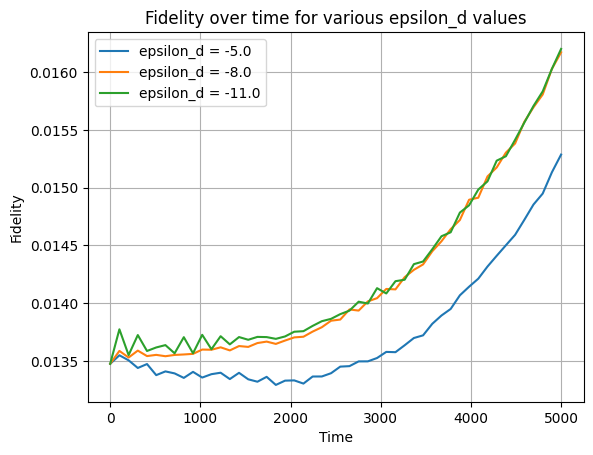

We also looked into how the parity may change over time.

In [ ]:
for i in range(res.states.shape[0]):
    # Define the parity operator for mode A
    parity_op = dq.parity(n_fock_a)

    # Compute expectation value of parity over time
    A = dq.ptrace(res.states, 0)[i]
    parity_values = np.real(dq.expect(parity_op, A))

    plt.plot(tsave, parity_values, label=f"epsilon_d = {epsilon_d[i]}")
    plt.xlabel("Time")
    plt.ylabel("Parity")
    plt.title("Photon Number Parity in Memory Mode")
plt.legend()
plt.grid()
plt.show()

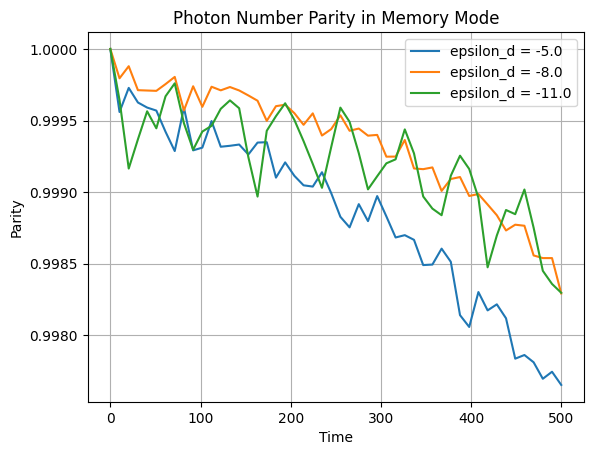